In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lib_detection import load_model, detect_lp, im2single
import keras
import tensorflow
from keras.models import model_from_json
from keras.models import Sequential

In [2]:
wpod_net_path = "wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)
model = Sequential()
json_file = open('/content/License_plate_nvidia.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('/content/License_plate_nvidia.h5')



In [17]:
def sort_contours(cnts, method="left-to-right"):

    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts)

In [4]:
digit_names = ('0','1','2','3','4','5','6','7','8','CHA','GA')

def model_predict(image):
    global digit_names
    import numpy as np
    import cv2
    img = np.asarray(image,dtype=np.float32)
    img = cv2.resize(img,(80,224))
    img = img/255
    img = img[np.newaxis,:]
    if len(img.shape)<4:
        img = np.stack((img,)*3, axis=-1)
    max_value = max((model.predict(img)[0]))
    index = np.where(model.predict(img)[0]==max_value)
    return digit_names[int(index[0])]

DHAKA METRO-CHA 3 2 4 3 5 4
DHAKA METRO-GA 2 0 1 3 6 2
1 5 8 3 2 3
DHAKA METRO-GA 3 0 2 6 3
1 1 2 8 7 4 0
DHAKA METRO-GA 1 1 0 3 4 6
DHAKA METRO-GA 2 1 5 8 3 7


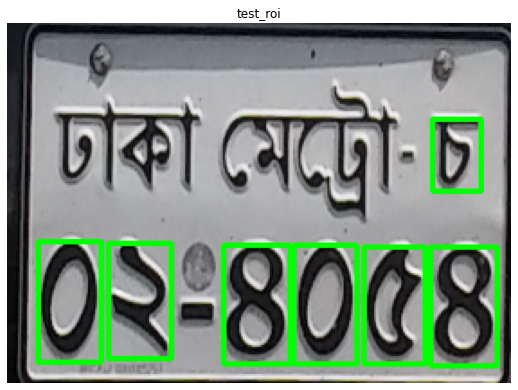

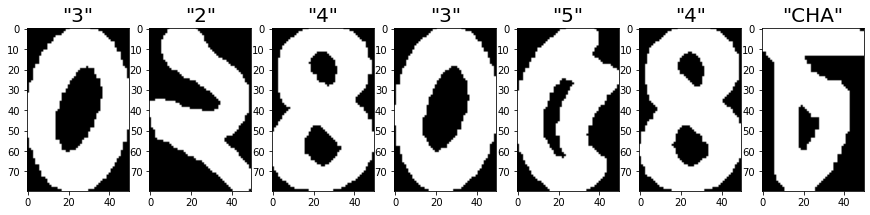

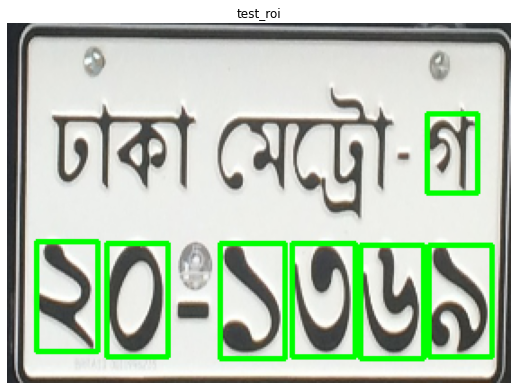

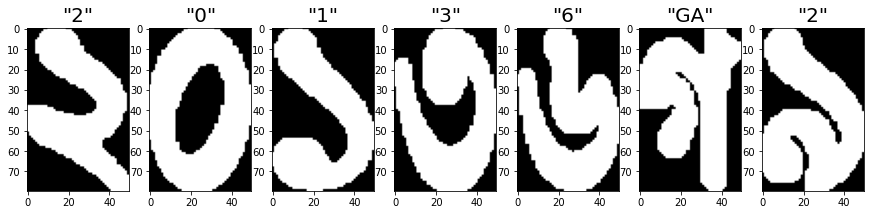

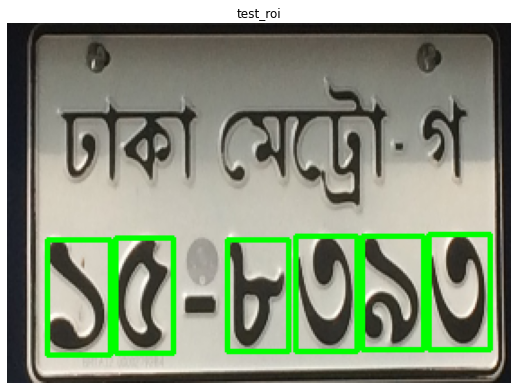

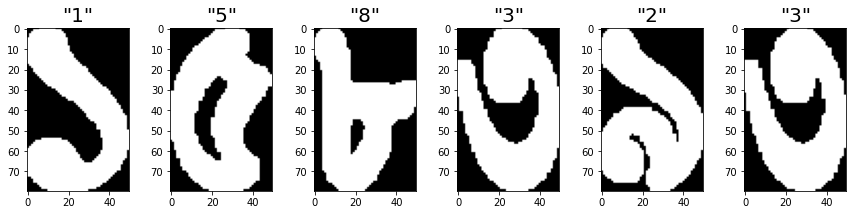

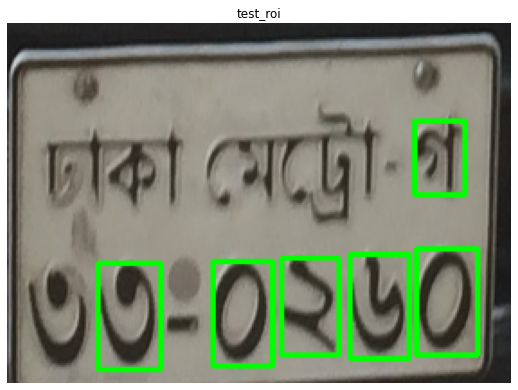

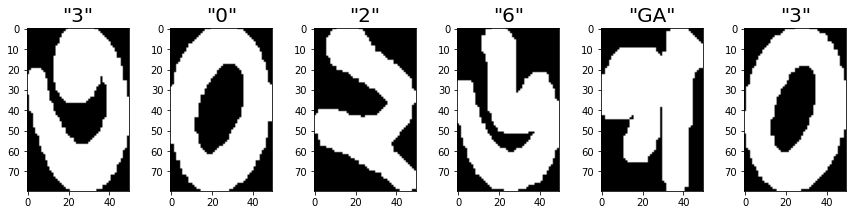

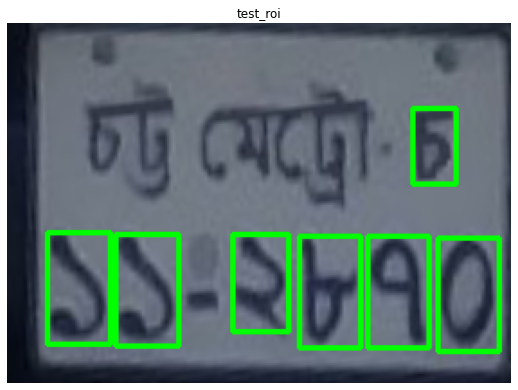

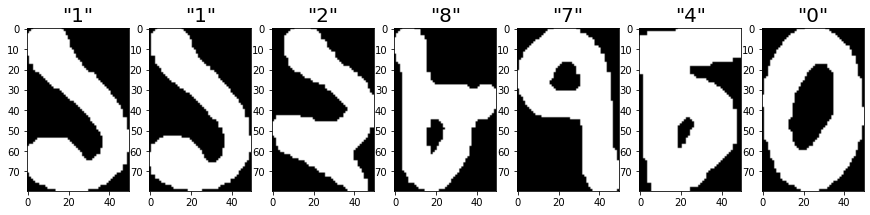

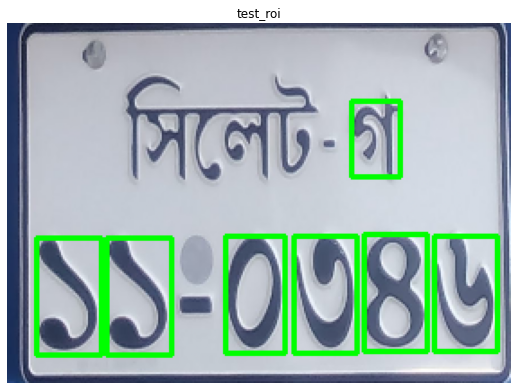

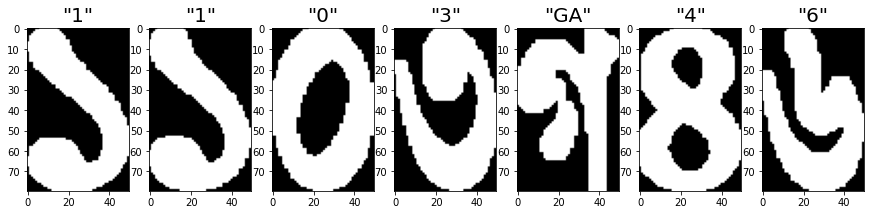

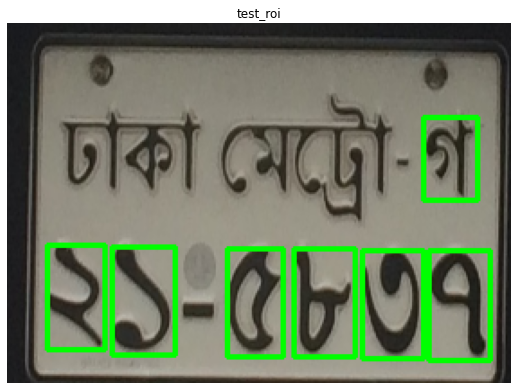

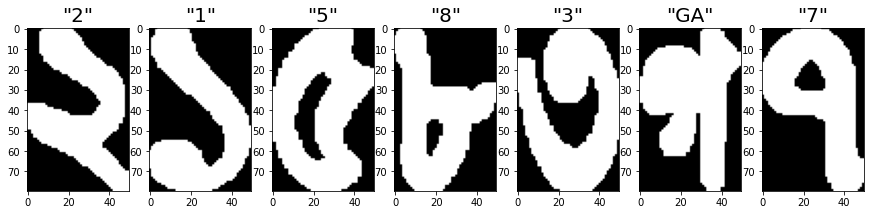

In [141]:


def detect_plate(vehicle):


  Dmax = 608
  Dmin = 288

  ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
  side = int(ratio * Dmin)
  bound_dim = min(side, Dmax)

  L , LpImg, lp_type = detect_lp(wpod_net, im2single(vehicle), bound_dim, lp_threshold=0.5)
# print("Detect %i plate(s)"%len(LpImg))


  if (len(LpImg)):

    # Scales, calculates absolute values, and converts the result to 8-bit.
      plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

      roi = LpImg[0]

    # convert to grayscale
      gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
      blur = cv2.GaussianBlur(gray,(7,7),0)

    # Applied inversed thresh_binary 
      binary = cv2.threshold(blur, 180, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
  cont, _  = cv2.findContours(thre_mor, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  digit_w = 50
  digit_h = 80 

  plate_info = ""

# crop 
  test_roi = roi.copy()
  crop_digits = []

  for c in sort_contours(cont):
      (x, y, w, h) = cv2.boundingRect(c)
      ratio = h/w
      if 1.4<=ratio<=2: # Only select contour with defined ratio
          if (h/roi.shape[0]>=0.2):
              cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)
              curr_num = thre_mor[y:y+h,x:x+w]
              curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
              _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
              crop_digits.append(curr_num)

  fig = plt.figure(figsize=(8,5))
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)      
  plt.imshow(test_roi)
  plt.title('test_roi')
#plt.savefig('grab_digit_contour.png',dpi=300)

  fig = plt.figure(figsize=(15,3))
  col = len(crop_digits)
  row = 1

  final_result = []
  val=''
  for digit in crop_digits:
      fig.add_subplot(1,col,row)
      title = model_predict(digit)
      final_result.append(title)
      plt.title('"%s"'%title,fontsize=20)
      plt.imshow(digit,cmap='gray')
      row+=1
  plt.savefig('digit_crops.png', dpi=300)

  for index, value in enumerate(final_result):
    if (value == 'GA') or (value == 'CHA'):
      final_result.pop(index)
      final_result.insert(0,"DHAKA METRO-"+value)

  listToStr = ' '.join([str(elem) for elem in final_result]) 
  print(listToStr) 

  # fig = plt.figure(figsize=(10,6))
  # ax = plt.Axes(fig, [0., 0., 1., 1.])
  # ax.set_axis_off()
  # fig.add_axes(ax)

  # final_image = cv2.copyMakeBorder(src=vehicle,top=0,bottom=200,left=0,right=0,
  #                                   borderType=cv2.BORDER_CONSTANT, value=[255,255,255])
  # h,w = final_image.shape[:2]
  # cv2.putText(final_image,listToStr,(int(w/3-150),int(h-80)),cv2.FONT_HERSHEY_DUPLEX,3,(0,0,255),5,cv2.LINE_AA)
  # plt.imshow(final_image)
  # plt.savefig('vehicle_with_prediction.png', dpi=300)
vehicle_image = plt.imread("/content/nature.jpg")
detect_plate(vehicle_image)

vehicle_image = plt.imread("/content/noisy.JPG")
detect_plate(vehicle_image)

vehicle_image = plt.imread("/content/shdw.JPG")
detect_plate(vehicle_image)

vehicle_image = plt.imread("/content/side.JPG")
detect_plate(vehicle_image)

vehicle_image = plt.imread("/content/small.jpg")
detect_plate(vehicle_image)

vehicle_image = plt.imread("/content/syl.jpg")
detect_plate(vehicle_image)

vehicle_image = plt.imread("/content/wnb.JPG")
detect_plate(vehicle_image)


In [112]:
# vehicle_image = plt.imread("/content/bnw.jpg")
# detect_plate(vehicle_image)

